### 1 - PREPARAÇÃO E CARREGAMENTO DOS DADOS ###

In [ ]:
import matplotlib as mplt
import seaborn as sns
import numpy as np
import pandas as pd

ModuleNotFoundError: No module named 'matplotlib'

In [19]:
try: 
    df = pd.read_csv("flight_data_2024.csv")
    print("Arquivo carregado com sucesso!")

except FileNotFoundError:
    print("ERRO: Arquivo não encontrado")

print(f"Dataset carregado com {df.shape[0]} linhas e {df.shape[1]} colunas.")

Arquivo carregado com sucesso!
Dataset carregado com 1048575 linhas e 18 colunas.


### 2 - INSPEÇÃO E QUALIDADE DOS DADOS ###

In [3]:
print("\n --- 2.1. Primeiras linhas ---")
display(df.head())


 --- 2.1. Primeiras linhas ---


,year,month,day_of_month,day_of_week,fl_date,origin,origin_city_name,origin_state_nm,dep_time,taxi_out,wheels_off,wheels_on,taxi_in,cancelled,air_time,distance,weather_delay,late_aircraft_delay
0,2024,1,1,1,1/1/2024,JFK,"New York, NY",New York,1247.0,31.0,1318.0,1442.0,7.0,0,84.0,509,0,0
1,2024,1,1,1,1/1/2024,MSP,"Minneapolis, MN",Minnesota,1001.0,20.0,1021.0,1249.0,6.0,0,88.0,622,0,0
2,2024,1,1,1,1/1/2024,JFK,"New York, NY",New York,1411.0,21.0,1432.0,1533.0,8.0,0,61.0,288,0,0
3,2024,1,1,1,1/1/2024,RIC,"Richmond, VA",Virginia,1643.0,13.0,1656.0,1747.0,12.0,0,51.0,288,0,0
4,2024,1,1,1,1/1/2024,DTW,"Detroit, MI",Michigan,1010.0,21.0,1031.0,1016.0,4.0,0,45.0,237,0,0


In [38]:
print(f"--- Descrição dos dados ---")
display(df.describe().T)

--- Descrição dos dados ---


,count,mean,std,min,25%,50%,75%,max
year,1048575.0,2024.000000,0.000000,2024.0,2024.0,2024.0,2024.0,2024.0
month,1048575.0,1.478081,0.499520,1.0,1.0,1.0,2.0,2.0
day_of_month,1048575.0,15.305120,8.585503,1.0,8.0,15.0,23.0,31.0
day_of_week,1048575.0,3.893483,2.010038,1.0,2.0,4.0,6.0,7.0
dep_time,1026022.0,1325.073671,497.299032,1.0,911.0,1323.0,1736.0,2400.0
taxi_out,1025450.0,18.250121,10.440251,1.0,12.0,15.0,21.0,213.0
wheels_off,1025450.0,1349.995608,498.042601,1.0,929.0,1337.0,1750.0,2400.0
wheels_on,1024898.0,1476.155761,519.868238,1.0,1058.0,1510.0,1914.0,2400.0
taxi_in,1024898.0,8.082517,6.512591,1.0,4.0,6.0,9.0,444.0
cancelled,1048575.0,0.022226,0.147419,0.0,0.0,0.0,0.0,1.0


In [34]:
voos_cancelados = df[df['cancelled'] == 1].copy()
cidades_distintas = voos_cancelados['origin_city_name'].dropna().unique().tolist()
total_cidades = len(cidades_distintas)
total_cancelamentos = voos_cancelados['cancelled'].sum()

print(f'O total de cidades de origem distinctas: {total_cidades}')
print(f'O total de Voos cancelados é: {total_cancelamentos}')


O total de cidades de origem distinctas: 301
O total de Voos cancelados é: 23306


In [2]:
cancelamentos_por_cidade = (
    df.groupby('origin_city_name')['cancelled'].sum().sort_values(ascending=False)
)

cidades_com_mais_cancelamentos = cancelamentos_por_cidade.head(15)
print(f"\n --- Gerando Gráfico: TOP 15 cidades por número de cancelamentos ---")

plt.figure(figsize=(14, 7))

grafico = sns.barplot(
    x=cidades_com_mais_cancelamentos.index,
    y=cidades_com_mais_cancelamentos.values,
    palette="Reds_d"
)

NameError: name 'df' is not defined

In [4]:
print("\n --- 2.3. Contagem de valores nulos ---")
nulos = df.isnull().sum().sort_values(ascending=False)
nulos_percentual = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
df_nulos = pd.DataFrame({'Nulos': nulos, 'Percentual': nulos_percentual})
print(df_nulos[df_nulos['Nulos'] > 0]) # Exibe apenas colunas com nulos


 --- 2.3. Contagem de valores nulos ---
            Nulos  Percentual
air_time    25751    2.455809
wheels_on   23677    2.258017
taxi_in     23677    2.258017
taxi_out    23125    2.205374
wheels_off  23125    2.205374
dep_time    22553    2.150824


C:\Users\phein\AppData\Local\Temp\ipykernel_39136\3441574223.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=contagem_mensal.index, y=contagem_mensal.values, palette="viridis")


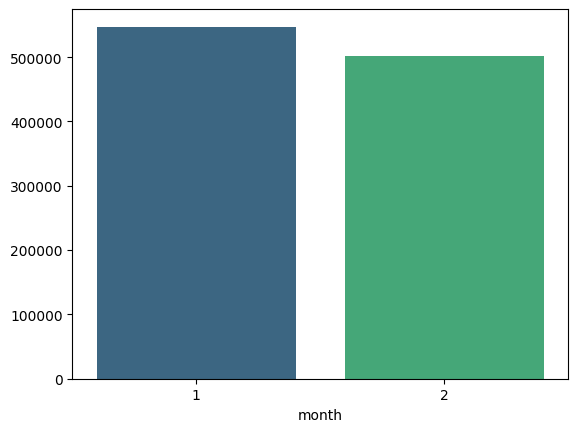

In [5]:
# 2. Contagem das Observações por Mês
    # value_counts() conta a frequência e sort_index() garante a ordem correta dos meses (1, 2, 3...)
contagem_mensal = df['month'].value_counts().sort_index()

# 3. Criação do Gráfico de Barras
ax = sns.barplot(x=contagem_mensal.index, y=contagem_mensal.values, palette="viridis")


### Inferencias iniciais ###

- O Dataset refere-se ao histórico de voos de 2024, porém só possui informações de vôos nos meses de Janeiro e Fevereiro (1 e 2);
- As informaçoes nulas do dataset se concentram nas variáveis associadas a tempo.

In [33]:
coluna_alvo = 'cancelled'

try:
    colunas_em_atraso = ['weather_delay', 'late_aircraft_delay']
    for col in colunas_em_atraso:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    if coluna_alvo in df.columns:
        df[coluna_alvo] = df[coluna_alvo].astype(int)
    else:
        # Se 'cancelled' não existe por algum motivo:
        raise KeyError(f"A coluna alvo '{coluna_alvo}' não foi encontrada no DataFrame. Não é possível prosseguir.")

    print("----- 1. Extração de features de tempo (fl_date) -----")

    df['fl_date'] = pd.to_datetime(df['fl_date'], errors='coerce')

    df['day_of_year'] = df['fl_date'].dt.dayofyear
    df['week_of_year'] = df['fl_date'].dt.isocalendar().week.astype(int)

    # Feature de Desempenho
    df['is_long_taxi_out'] = np.where(df['taxi_out'] > 20, 1, 0)


    if 'late_aircraft_delay' in df.columns:
        df['is_delayed'] = np.where(df['late_aircraft_delay'] > 15, 1, 0)
        print("-> Variável 'is_delayed' (Target) criada com sucesso.")

    print("\n--- 2. Codificação de Variáveis Categóricas (One-Hot Encoding) ---")

    colunas_para_dummies = ['origin', 'origin_state_nm']

    df = pd.get_dummies(df, columns=colunas_para_dummies, drop_first=True)
    
    print(f"-> Colunas {colunas_para_dummies} codificadas.")

   # 4. REMOÇÃO DE COLUNAS DESNECESSÁRIAS
    # Remove a data original (agora temos as features de tempo) e o 'fl_date' original.
    colunas_para_remover = ['fl_date']
    df.drop(columns=colunas_para_remover, inplace=True, errors='ignore')
    
    
    # 5. VERIFICAÇÃO FINAL
    print("\n--- Verificação do DataFrame Final (Primeiras Linhas e Colunas) ---")
    print(df.head())
    print(f"\nNovo shape do DataFrame: {df.shape}")
    print(f"\n🚨 O próximo passo é usar a coluna '{COLUNA_ALVO}' (cancelled) como Y.")


except Exception as e:
    print(f"Ocorreu um erro durante a modelagem: {e}")

----- 1. Extração de features de tempo (fl_date) -----
-> Variável 'is_delayed' (Target) criada com sucesso.

--- 2. Codificação de Variáveis Categóricas (One-Hot Encoding) ---
-> Colunas ['origin', 'origin_state_nm'] codificadas.

--- Verificação do DataFrame Final (Primeiras Linhas e Colunas) ---
   year  month  day_of_month  day_of_week origin_city_name  dep_time  \
0  2024      1             1            1     New York, NY    1247.0   
1  2024      1             1            1  Minneapolis, MN    1001.0   
2  2024      1             1            1     New York, NY    1411.0   
3  2024      1             1            1     Richmond, VA    1643.0   
4  2024      1             1            1      Detroit, MI    1010.0   

   taxi_out  wheels_off  wheels_on  taxi_in  ...  origin_state_nm_Texas  \
0      31.0      1318.0     1442.0      7.0  ...                  False   
1      20.0      1021.0     1249.0      6.0  ...                  False   
2      21.0      1432.0     1533.0      8.

In [31]:
display(df.head())

,year,month,day_of_month,day_of_week,fl_date,origin_city_name,dep_time,taxi_out,wheels_off,wheels_on,...,origin_state_nm_Texas,origin_state_nm_U.S. Pacific Trust Territories and Possessions,origin_state_nm_U.S. Virgin Islands,origin_state_nm_Utah,origin_state_nm_Vermont,origin_state_nm_Virginia,origin_state_nm_Washington,origin_state_nm_West Virginia,origin_state_nm_Wisconsin,origin_state_nm_Wyoming
0,2024,1,1,1,2024-01-01,"New York, NY",1247.0,31.0,1318.0,1442.0,...,False,False,False,False,False,False,False,False,False,False
1,2024,1,1,1,2024-01-01,"Minneapolis, MN",1001.0,20.0,1021.0,1249.0,...,False,False,False,False,False,False,False,False,False,False
2,2024,1,1,1,2024-01-01,"New York, NY",1411.0,21.0,1432.0,1533.0,...,False,False,False,False,False,False,False,False,False,False
3,2024,1,1,1,2024-01-01,"Richmond, VA",1643.0,13.0,1656.0,1747.0,...,False,False,False,False,False,True,False,False,False,False
4,2024,1,1,1,2024-01-01,"Detroit, MI",1010.0,21.0,1031.0,1016.0,...,False,False,False,False,False,False,False,False,False,False
